## Extension 1: Including the cross correlations between bins

Similar exploration and plots as before, but now including the cross-correlations between bins.

In [1]:
# Import stuff
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate 
from code.plot_utils import plot_pretty
from matplotlib import rcParams
rcParams['font.family'] = 'serif' 
%matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Ang_clust_WITH_cross import Fisher_calculator as Fisher_CROSS

Inputs of the function Fisher_CROSS (calculates Angular clustering in a given number of bins between given limits, taking into account the cross-correlations between bins)

Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_z, N_gal_tot, z_0, a, b)

- z_init, z_final : redshift limits we consider

- N_bis: number of bins

- f_sky: fraction of the sky used

- sig_z: photo-z scatter

- N_gal_tot: total number of galaxies

- z_0, a, b : parameters that describe the distribution

In [3]:
# Import function that marginalizes over the the nuisance parameters
from Tools import marginalize as marg
# Import function that adds a constant prior of the form sigma(sigma_z) = sigma(z_b), same in every bin
from Tools import priors_1
# Import function that adds a constant prior of the form sigma(sigma_z) = sigma(z_b) = alpha*sigma_z, same in every bin
from Tools import priors_2
# Import function that calculates Figure of Merit
from Tools import FoM_return 

In [7]:
# Arrays of sample sizes and redshift errors 
# ======================================================
N_gal_arr = np.linspace(1.0e6, 7.0e7, 35)
sig_z_arr = np.linspace(0.01, 0.1, 35)
size = np.size(N_gal_arr)

In [8]:
# Survey parameters for the Fisher matrix 
# =====================================================
# =====================================================
z_init =  0.20 #Initial redshift
z_final = 0.95 #Final redshift
N_bins = 5 #Number of bins
f_sky = 4580.0/41253.0 # Fraction of the sky

# Parameters of the redshift distribution
z_0 = 0.75
a = 1.0
b = 3.43
# =====================================================
# =====================================================
# Parameters (size and redshift error for the particular samples I'm going to consider)

# redMaGiC-like sample
N_g_rm, sig_rm = 2.67e6, 0.0166
# BAO-cuts like sample
N_g_BAO, sig_BAO = 1.567e7, 0.031
# Flux-limited like sample
N_g_fl, sig_fl = 5.73e7, 0.082

#### Define some priors - as before

In [9]:
# Define the optimistic and conservative see above
alpha_con = 0.4
alpha_opt = 0.04
# Define also an alpha that will actually result in fixed photo-z errors
# In other words, knowledge of the photo-zs with infinite accuracy
alpha_fix = 1.0e-10

#### Calculate FoM grids

In [10]:
# Initialize matrices
FoM_free = np.zeros([size,size])
FoM_pr_con = np.zeros([size,size]) # Conservative prior case
FoM_pr_opt = np.zeros([size,size]) # Optimistic prior case
FoM_fixed = np.zeros([size, size]) # Fixed photo-zs


for i in range(size):
    sig_z = sig_z_arr[i]
    for j in range(size):
        N_gal = N_gal_arr[j]
        
        #Calculate the free Fisher matrix 
        Fish_mat = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_z, N_gal, z_0, a, b)
        
        # Add the priors now 
        # ------------------------------------------------------------
        Fish_pr_con = priors_2(Fish_mat, N_bins, alpha_con, sig_z) #conservative prior
        Fish_pr_opt = priors_2(Fish_mat,N_bins, alpha_opt, sig_z) #optimistic prior
        Fish_fix = priors_2(Fish_mat, N_bins, alpha_fix, sig_z) # Fixed photo-z parameters
        
        #Calculate the Figure of Merit
        FoM_free[i][j] = FoM_return(Fish_mat)
        FoM_pr_con[i][j] = FoM_return(Fish_pr_con)
        FoM_pr_opt[i][j] = FoM_return(Fish_pr_opt)
        FoM_fixed[i][j] = FoM_return(Fish_fix)

#### Calculate the FoMs of the redMaGiC, BAO and Flux Limited samples 

In [11]:
# Calculate the Fisher matrices - without priors for the three samples
Fish_mat_rm_free = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_rm, N_g_rm, z_0, a, b)
Fish_mat_BAO_free = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_BAO, N_g_BAO, z_0, a, b)
Fish_mat_fl_free = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_fl, N_g_fl, z_0, a, b)

# ===========================================================================================
# ===========================================================================================

# Include the three priors

# Conservative priors
Fish_rm_con = priors_2(Fish_mat_rm_free, N_bins, alpha_con, sig_rm)
Fish_BAO_con = priors_2(Fish_mat_BAO_free, N_bins, alpha_con, sig_BAO)
Fish_fl_con = priors_2(Fish_mat_fl_free, N_bins, alpha_con, sig_fl)

# Optimistic priors
Fish_rm_opt = priors_2(Fish_mat_rm_free, N_bins, alpha_opt, sig_rm)
Fish_BAO_opt = priors_2(Fish_mat_BAO_free, N_bins, alpha_opt, sig_BAO)
Fish_fl_opt = priors_2(Fish_mat_fl_free, N_bins, alpha_opt, sig_fl)

# Fixed photo-zs 
Fish_rm_fix = priors_2(Fish_mat_rm_free, N_bins,alpha_fix, sig_rm)
Fish_BAO_fix = priors_2(Fish_mat_BAO_free, N_bins, alpha_fix, sig_BAO)
Fish_fl_fix = priors_2(Fish_mat_fl_free, N_bins, alpha_fix, sig_fl)

# ============================================================================================
# ============================================================================================

# Now calculate the FoMs

# Free - no priors
FoM_rm_free = FoM_return(Fish_mat_rm_free)
FoM_BAO_free = FoM_return(Fish_mat_BAO_free)
FoM_fl_free = FoM_return(Fish_mat_fl_free)

# Conservative priors
FoM_rm_con = FoM_return(Fish_rm_con)
FoM_BAO_con = FoM_return(Fish_BAO_con)
FoM_fl_con = FoM_return(Fish_fl_con)

# Optimistic priors
FoM_rm_opt = FoM_return(Fish_rm_opt)
FoM_BAO_opt = FoM_return(Fish_BAO_opt)
FoM_fl_opt = FoM_return(Fish_fl_opt)

# Fixed photo-zs
FoM_rm_fix = FoM_return(Fish_rm_fix)
FoM_BAO_fix = FoM_return(Fish_BAO_fix)
FoM_fl_fix = FoM_return(Fish_fl_fix)

### Normalize matrices and plot now


#### I) Free photo-zs

In [12]:
# Normalize the matrix now
# =================================================
FoM_free_tr = np.matrix.transpose(np.copy(FoM_free))
FoM_free_norm = np.copy(FoM_free_tr)/(FoM_rm_free)

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  s)


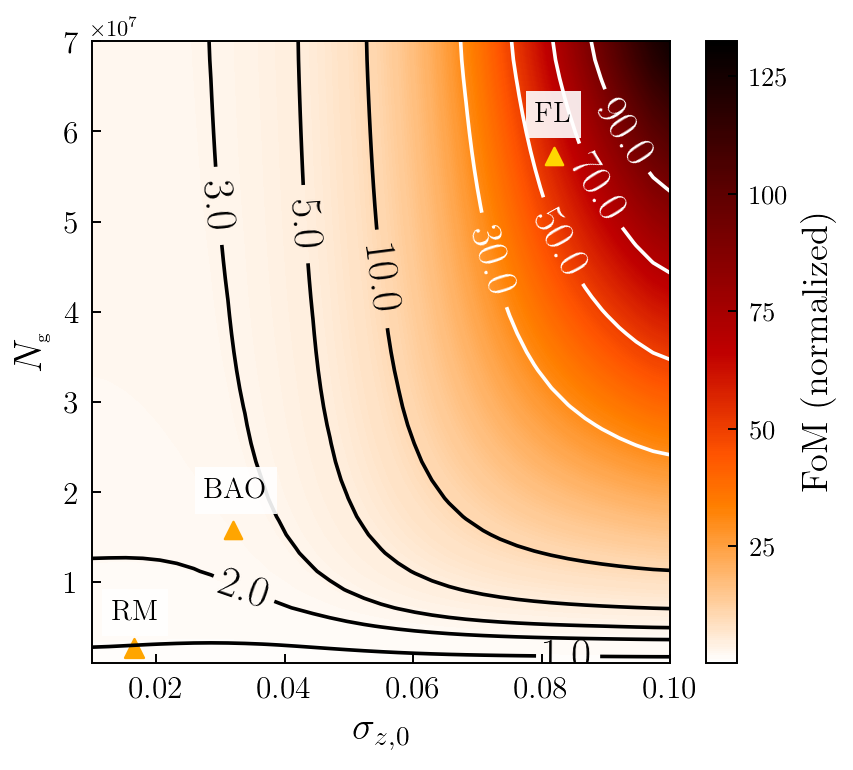

In [13]:
plot_pretty()
import scipy.ndimage
def FoM_free_return(a_1,a_2):
    FoMino = np.copy(FoM_free_norm)
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_free = np.copy(FoM_free_return(a_1, a_2))

FoM_free = scipy.ndimage.gaussian_filter(FoM_free, 1)
levels = np.linspace(np.min(FoM_free_norm),np.max(FoM_free_norm),300)
image = plt.contourf(a_1, a_2, FoM_free , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_free, [1.0,2,3,5,10,30,50, 70,90] , colors=('k','k', 'k', 'k', 'k','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.3)
plt.clabel(C, inline=1, fontsize=18, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(0.082,5.73e7, color='gold', s=50.0, marker='^')
plt.text(0.079, 6.1e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(0.032,1.57e7, color='orange', s=50.0, marker='^')
plt.text(0.0275, 1.92e7,'BAO', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(0.0166,2.67e6, color='orange', s=60.0, marker='^')
plt.text(0.0131, 5.7e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=13)

plt.xlabel("$\sigma_{z,0}$", fontsize=16);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=16)


plt.xlim(0.01,0.1);plt.ylim(1.0e6, 7.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[25,50,75,100,125,150])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([25,50,75,100,125,150], fontsize=11)

plt.tight_layout()
plt.savefig('With_cross_free.pdf')
plt.show() 

#### II) Conservative priors, $\alpha = 0.4$

In [14]:
# Normalize the matrix
# =================================================
FoM_pr_con_tr = np.matrix.transpose(np.copy(FoM_pr_con))
FoM_pr_con_norm = np.copy(FoM_pr_con_tr)/(FoM_rm_con)

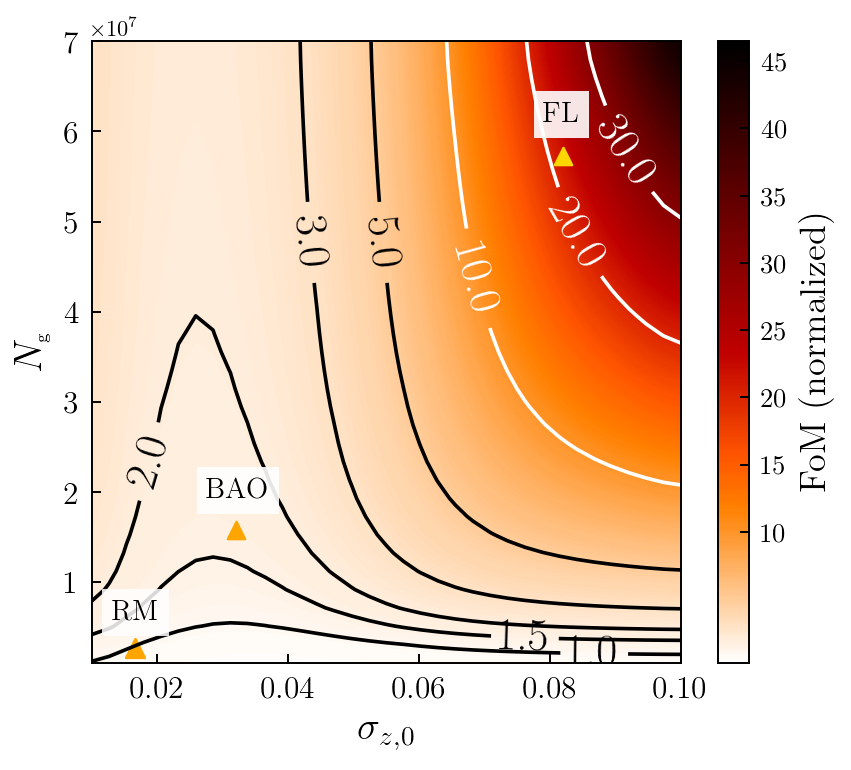

In [17]:
def FoM_pr_con_return(a_1,a_2):
    FoMino = np.copy(FoM_pr_con_norm)
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_pr_cons = np.copy(FoM_pr_con_return(a_1, a_2))

FoM_pr_cons = scipy.ndimage.gaussian_filter(FoM_pr_cons, 1)
levels = np.linspace(np.min(FoM_pr_con_norm),np.max(FoM_pr_con_norm),300)
image = plt.contourf(a_1, a_2, FoM_pr_cons , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_pr_cons, [1.0,1.5,2.0,3.0,5,10,20,30] , colors=('k','k', 'k', 'k', 'k','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.3)
plt.clabel(C, inline=1, fontsize=19, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(0.082,5.73e7, color='gold', s=50.0, marker='^')
plt.text(0.079, 6.10e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(0.032,1.57e7, color='orange', s=50.0, marker='^')
plt.text(0.0275, 1.92e7,'BAO', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(0.0166,2.67e6, color='orange', s=60.0, marker='^')
plt.text(0.0131, 5.7e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=13)

plt.xlabel("$\sigma_{z,0}$", fontsize=16);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=16)


plt.xlim(0.01,0.1);plt.ylim(1.0e6, 7.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[10,15,20,25,30,35,40,45,50])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([10,15,20,25,30,35,40,45,50], fontsize=11)

plt.tight_layout()
plt.savefig('Cross_cons_priors.pdf')
plt.show() 

#### III) Optimistic priors, $\alpha = 0.04$

In [18]:
# Normalize the matrix now
# =================================================
FoM_pr_opt_tr = np.matrix.transpose(np.copy(FoM_pr_opt))
FoM_pr_opt_norm = np.copy(FoM_pr_opt_tr)/(FoM_rm_opt)

In [ ]:
def FoM_pr_opt_return(a_1,a_2):
    FoMino = np.copy(FoM_pr_opt_norm)
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_pr_opt = np.copy(FoM_pr_opt_return(a_1, a_2))

FoM_pr_opt = scipy.ndimage.gaussian_filter(FoM_pr_opt, 1)
levels = np.linspace(np.min(FoM_pr_opt_norm),np.max(FoM_pr_opt_norm),300)
image = plt.contourf(a_1, a_2, FoM_pr_opt , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_pr_opt, [1.0,1.5,2.0,5.0,10,20,30] , colors=('k','k', 'k', 'k', 'w','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.4)
plt.clabel(C, inline=1, fontsize=19, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(0.082,5.73e7, color='gold', s=50.0, marker='^')
plt.text(0.079, 5.20e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(0.032,1.57e7, color='gold', s=50.0, marker='^')
plt.text(0.0275, 1.92e7,'BAO', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(0.0166,2.67e6, color='gold', s=60.0, marker='^')
plt.text(0.0131, 5.7e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=13)

plt.xlabel("$\sigma_{z,0}$", fontsize=16);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=16)


plt.xlim(0.01,0.1);plt.ylim(1.0e6, 7.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[5,10,15,20,25,30,35])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([5,10,15,20,25,30,35], fontsize=11)

plt.tight_layout()
plt.savefig('Cross_optim_priors.pdf')
plt.show() 

#### IV) Fixed photo-zs

In [62]:
# Normalize the matrix
# =================================================
FoM_fixed_tr = np.matrix.transpose(np.copy(FoM_fixed))
FoM_fixed_norm = np.copy(FoM_fixed_tr)/(FoM_rm_fix)

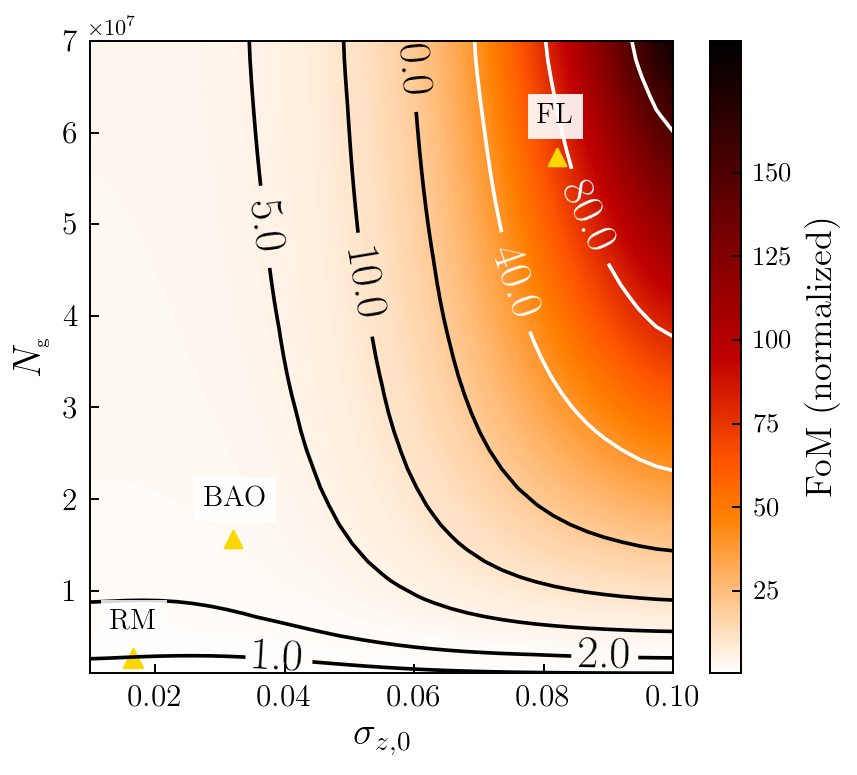

In [72]:
def FoM_fix_return(a_1,a_2):
    FoMino = np.copy(FoM_fixed_norm)
    return FoMino
# =============================================================================
# =============================================================================
fig = plt.figure(figsize = (5.0,4.5))

a_1, a_2 = np.meshgrid(sig_z_arr,N_gal_arr )
FoM_fix_pr = np.copy(FoM_fix_return(a_1, a_2))

FoM_fix_pr = scipy.ndimage.gaussian_filter(FoM_fix_pr, 1)
levels = np.linspace(np.min(FoM_fixed_norm),np.max(FoM_fixed_norm),300)
image = plt.contourf(a_1, a_2, FoM_fix_pr , levels=levels, cmap=plt.cm.gist_heat_r)
#===============================================================================
#===============================================================================

C = plt.contour(a_1,a_2, FoM_fix_pr, [1.0,2,5,10,20,40,80,150] , colors=('k','k', 'k', 'k', 'k','w', 'w', 'w', 'w','w','w','w','w','w'),linestyle ='--',  linewidth=2.4)
plt.clabel(C, inline=1, fontsize=19, fmt='%1.1f', fontweight='heavy')

#plt.yscale('log')


plt.scatter(0.082,5.73e7, color='gold', s=50.0, marker='^')
plt.text(0.079, 6.10e7,'FL', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(0.032,1.57e7, color='gold', s=50.0, marker='^')
plt.text(0.0275, 1.92e7,'BAO', color='black', fontsize=12,bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
plt.scatter(0.0166,2.67e6, color='gold', s=60.0, marker='^')
plt.text(0.0131, 5.7e6,'RM', color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='none', alpha=0.85))
plt.tick_params(axis='both', labelsize=13)

plt.xlabel("$\sigma_{z,0}$", fontsize=16);plt.ylabel("$N_{\mbox{\scriptsize{g}}}$", fontsize=16)


plt.xlim(0.01,0.1);plt.ylim(1.0e6, 7.0e7)

cbar = plt.colorbar(image, orientation='vertical', ticks=[25,50,75,100,125,150])
cbar.set_label('FoM (normalized)', fontsize=15)
cbar.ax.set_yticklabels([25,50,75,100,125,150], fontsize=11)

plt.tight_layout()
plt.savefig('Cross_fixed_phot.pdf')
plt.show() 

In [64]:
print(FoM_fl_free/FoM_rm_free)
print(FoM_fl_con/FoM_rm_con)
print(FoM_fl_opt/FoM_rm_opt)
print(FoM_fl_fix/FoM_rm_fix)


58.584327195415646
17.301767927668408
26.521314610812862
72.88544878033815


In [65]:
print(FoM_rm_free/4757.91119238056)


1.0421365987889464


In [73]:
print(FoM_rm_con/52539.64046185439)

1.0213442791625151


In [74]:
print(FoM_rm_opt/95294.5342013479)

1.02686313144923


In [75]:
print(FoM_rm_fix/96509.3852136991)

1.0270942151519786


### Further exploration on the dependence on photo-z priors

Exactly as before, but now including the cross correlations

In [76]:
# Define again the samples - N_g and \sigma_{z,0}
# =============================================
# redMaGiC-like sample
N_g_rm, sig_rm = 2.67e6, 0.0166
# BAO-cuts like sample
N_g_BAO, sig_BAO = 1.567e7, 0.031
# Intermediate sample
N_g_int, sig_int = 3.0e7, 0.05
# Flux-limited like sample
N_g_fl, sig_fl = 5.73e7, 0.082

#==================================================================
# Define the array in alpha
alpha_lin = np.linspace(-3.0,0.0,300)
alpha = 10.0**alpha_lin

In [77]:
# Calculate the free fisher matrices in the above cases - i.e. without any priors
Fish_rm_free = Fisher_CROSS(z_init, z_final, N_bins, f_sky,sig_rm, N_g_rm, z_0, a, b)
Fish_BAO_free = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_BAO, N_g_BAO, z_0, a, b)
Fish_int_free = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_int, N_g_int, z_0, a, b)
Fish_fl_free = Fisher_CROSS(z_init, z_final, N_bins, f_sky, sig_fl, N_g_fl, z_0, a, b)

In [78]:
# The figures of merit will be arrays as well - initialize them
FoM_rm = np.zeros(len(alpha))
FoM_BAO = np.zeros(len(alpha))
FoM_int = np.zeros(len(alpha))
FoM_fl = np.zeros(len(alpha))

# Populate the arrays now
for i in range(len(alpha)):
    Fisher_rm = np.copy(Fish_rm_free)
    Fisher_BAO = np.copy(Fish_BAO_free)
    Fisher_int = np.copy(Fish_int_free)
    Fisher_fl = np.copy(Fish_fl_free)
    
    # Add the priors now
    alpha_pr = alpha[i]
    
    Fish_rm_pr = priors_2(Fisher_rm, N_bins, alpha_pr, sig_rm)
    Fish_BAO_pr = priors_2(Fisher_BAO, N_bins, alpha_pr, sig_BAO)
    Fish_int_pr = priors_2(Fisher_int, N_bins, alpha_pr, sig_int)
    Fish_fl_pr = priors_2(Fisher_fl, N_bins, alpha_pr, sig_fl)
    
    # Calculate FoM - populate the i-th element of the array
    FoM_rm[i] = FoM_return(Fish_rm_pr)
    FoM_BAO[i] = FoM_return(Fish_BAO_pr)
    FoM_int[i] = FoM_return(Fish_int_pr)
    FoM_fl[i] = FoM_return(Fish_fl_pr)
    
# ===========================================================================
# ===========================================================================
# Normalize to the maximum FoM of the redMaGiC sample
FoM_rm_norm = FoM_rm/FoM_rm_fix
FoM_BAO_norm = FoM_BAO/FoM_rm_fix
FoM_int_norm = FoM_int/FoM_rm_fix
FoM_fl_norm = FoM_fl/FoM_rm_fix

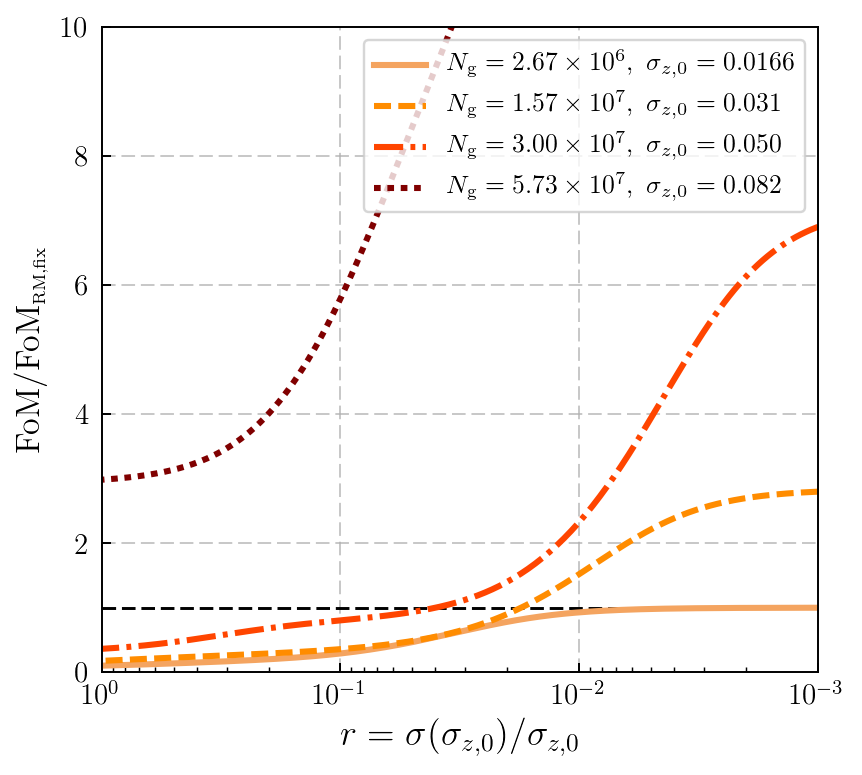

In [81]:
# Let's plot now
fig = plt.figure(figsize = (5.0,4.5))

plt.plot(alpha, FoM_rm_norm, linewidth=2.5, c='sandybrown', label=r'$N_{\mbox{\scriptsize{g}}}=2.67 \times 10^6, \,\, \sigma_{z,0} = 0.0166$')
plt.plot(alpha, FoM_BAO_norm, linewidth=2.5, c='darkorange',ls='--', label=r'$N_{\mbox{\scriptsize{g}}}=1.57 \times 10^7, \,\, \sigma_{z,0} = 0.031$')
plt.plot(alpha, FoM_int_norm, linewidth=2.5, c='orangered', ls='-.', label=r'$N_{\mbox{\scriptsize{g}}}=3.00 \times 10^7, \,\, \sigma_{z,0} = 0.050$')
plt.plot(alpha, FoM_fl_norm, linewidth=2.5, c='maroon', ls=':', label=r'$N_{\mbox{\scriptsize{g}}}= 5.73 \times 10^7, \,\, \sigma_{z,0} = 0.082$')


plt.hlines(1.0,1,1e-3, color='k', linestyle='--', linewidth= 1.2)

plt.ylabel('FoM/FoM$_{\scriptsize{\mbox{RM,fix}}}$',fontsize=14)
plt.xlabel(r'$r = \sigma(\sigma_{z,0})/\sigma_{z,0}$',fontsize=15)
plt.tick_params(axis='both', labelsize=12)


plt.grid(ls='--', alpha=0.7)

plt.legend(frameon=True, loc='upper right', fontsize=10.6)


plt.xscale('log');plt.xlim(1.0,1e-3);plt.ylim(0,10)

plt.tight_layout()

plt.savefig('FoM_priors_CROSS.pdf')
plt.show()